<a href="https://colab.research.google.com/github/gireek/karpathy_lectures/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/karpathy/micrograd

Only has 2 files

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

%matplotlib inline

In [3]:
def f(x):
  return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

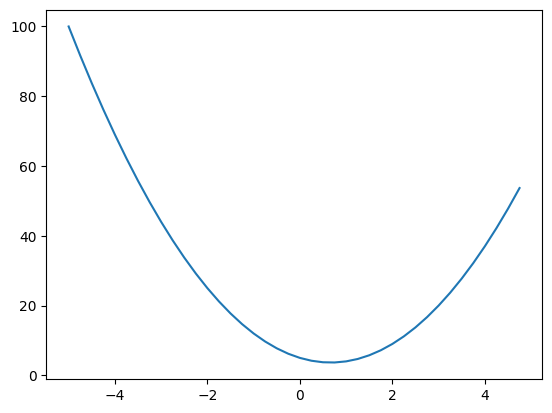

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

You cant do rule based derivatives for neural net models

In [6]:
h = 0.00000001
x = 2/3
f(x+h)

3.666666666666667

In [7]:
(f(x+h) - f(x))/h
# is 0 bcz derivative is zero at that point

0.0

In [8]:
# little complex

#inputs
a = 2.0
b = -3.0
c = 10.0

# d computation
d = a*b + c
d

4.0

t4esting for derivtive on a,b,c

In [9]:
d1 = a*b + c
a += h
d2 = a*b + c

(d2 - d1)/h

-2.999999981767587

In [10]:
d1 = a*b + c
b += h
d2 = a*b + c

(d2 - d1)/h

1.999999987845058

In [11]:
d1 = a*b + c
c += h
d2 = a*b + c

(d2 - d1)/h

1.000000082740371

Value object

In [12]:
class Value:
    def __init__(self, data, _children=(), _op="", label = ''): #_children is tuple but set inside
      self.data= data
      self._prev = set(_children)
      self._op = _op
      self.label = label
      self.grad = 0.0


    def __repr__(self):
        return f"Value(data={self.data})"


    def __add__(self, other): # using __add__ it will automatically be invoked when val1 + val2 is called
      out = Value(self.data + other.data, (self, other), "+")
      return out


    def __mul__(self, other): # using __mul__ it will automatically be invoked when val1*val2 is called
      out = Value(self.data*other.data, (self, other), "*")
      return out



a = Value(2.0)
b = Value(3.0)
print(a + b)
print(b.__add__(a))
print(a.__add__(b))

print(a*b)
print(b.__mul__(a))


Value(data=5.0)
Value(data=5.0)
Value(data=5.0)
Value(data=6.0)
Value(data=6.0)


In [13]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f
L.label = "L"

In [14]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [15]:
d._op

'+'

In [16]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | %s | grad %.4f}" % (n.data, n.label, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

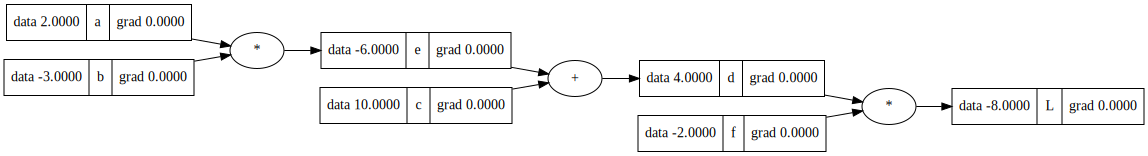

In [17]:
draw_dot(L)

In [18]:
L.grad = 1

In [19]:
def backprop(last_node):
  grad_here = last_node.grad

  if last_node._op == "+":
    for child in last_node._prev:
      child.grad = grad_here
      backprop(child)

  elif last_node._op == "*":
    child1,child2 = list(last_node._prev)[0], list(last_node._prev)[1]

    child1.grad = grad_here * child2.data
    backprop(child1)
    child2.grad = grad_here * child1.data
    backprop(child2)

  else:
    return

backprop(L)

In [20]:
for i in range(10):

  a.data += 0.01 * a.grad
  b.data += 0.01 * b.grad
  c.data += 0.01 * c.grad
  f.data += 0.01 * f.grad

  e = a*b
  d = e + c
  L = d*f

  print(L.data)

  L.grad = 1
  backprop(L)

-7.286496
-6.597755834428276
-5.9314458386892275
-5.285081843134573
-4.6560150657269235
-4.041415395804313
-3.438251441813934
-2.8432666409313563
-2.252950632362309
-1.6635049738718164


In [21]:
def lol():
  h = 0.0001

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  d = a*b + c
  d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d*f
  L.label = "L"
  L1 = L.data

  a = Value(2.0 + h, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  d = a*b + c
  d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d*f
  L.label = "L"
  L2 = L.data

  print((L2 - L1)/h)

lol()

6.000000000021544


In [23]:
class Value:
    def __init__(self, data, _children=(), _op="", label = ''): #_children is tuple but set inside
      self.data= data
      self._prev = set(_children)
      self._op = _op
      self.label = label
      self.grad = 0.0


    def __repr__(self):
        return f"Value(data={self.data})"


    def __add__(self, other): # using __add__ it will automatically be invoked when val1 + val2 is called
      out = Value(self.data + other.data, (self, other), "+")
      return out


    def __mul__(self, other): # using __mul__ it will automatically be invoked when val1*val2 is called
      out = Value(self.data*other.data, (self, other), "*")
      return out

    def tanh(self):
      x = self.data
      t = ((math.exp(2*x) - 1)/(math.exp(2*x) + 1))
      out = Value(t, (self,), 'tanh')
      return out

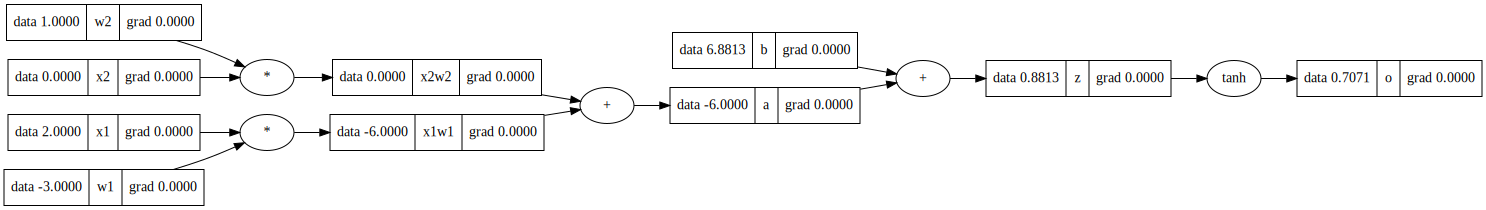

In [26]:
# NEURON

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

b = Value(6.8813, label="b")

x1w1 = x1*w1
x1w1.label = "x1w1"

x2w2 = x2*w2
x2w2.label = "x2w2"

a = x1w1 + x2w2
a.label = "a"

z = a + b
z.label = "z"

o = z.tanh()
o.label = 'o'

draw_dot(o)

In [27]:
o.grad = 1

def backprop(last_node):
  grad_here = last_node.grad

  if last_node._op == "+":
    for child in last_node._prev:
      child.grad = grad_here
      backprop(child)

  elif last_node._op == "*":
    child1,child2 = list(last_node._prev)[0], list(last_node._prev)[1]

    child1.grad = grad_here * child2.data
    backprop(child1)
    child2.grad = grad_here * child1.data
    backprop(child2)

  elif last_node._op == "tanh":
    child1 = list(last_node._prev)[0]
    child1.grad = grad_here * (1 - last_node.data*last_node.data)
    backprop(child1)

  else:
    return

backprop(o)

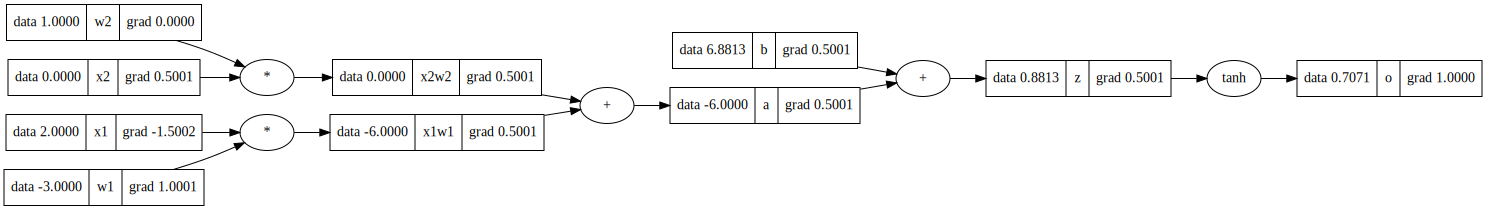

In [28]:
draw_dot(o)

In [55]:
# without an explicit backward function



class Value:
    def __init__(self, data, _children=(), _op="", label = ''): #_children is tuple but set inside
      self.data= data
      self._prev = set(_children)
      self._backward = lambda: None #empty function bcz for leaf node it needs to do nothing and return. therefore cant be None
      self._op = _op
      self.label = label
      self.grad = 0.0


    def __repr__(self):
        return f"Value(data={self.data})"


    def __add__(self, other): # using __add__ it will automatically be invoked when val1 + val2 is called
      out = Value(self.data + other.data, (self, other), "+")

      def _backward():
        self.grad = 1.0 * out.grad
        other.grad = 1.0 * out.grad
      out._backward = _backward

      return out


    def __mul__(self, other): # using __mul__ it will automatically be invoked when val1*val2 is called
      out = Value(self.data*other.data, (self, other), "*")

      def _backward():
        self.grad = other.data * out.grad
        other.grad = self.data * out.grad
      out._backward = _backward

      return out

    def tanh(self):
      x = self.data
      t = ((math.exp(2*x) - 1)/(math.exp(2*x) + 1))
      out = Value(t, (self,), 'tanh')

      def _backward():
        self.grad = (1 - t**2) * out.grad
      out._backward = _backward

      return out


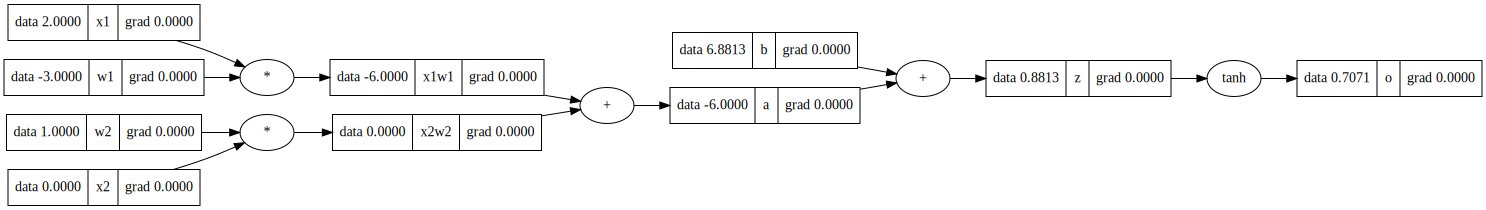

In [56]:
# NEURON

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

b = Value(6.8813, label="b")

x1w1 = x1*w1
x1w1.label = "x1w1"

x2w2 = x2*w2
x2w2.label = "x2w2"

a = x1w1 + x2w2
a.label = "a"

z = a + b
z.label = "z"

o = z.tanh()
o.label = 'o'

draw_dot(o)

In [57]:
o.grad = 1

o._backward()

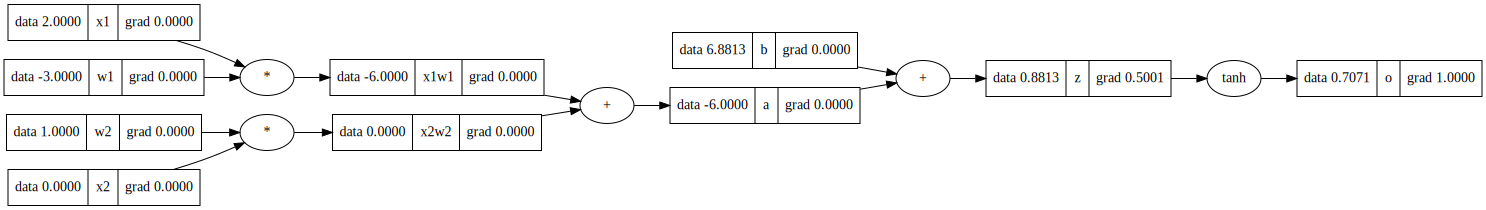

In [58]:
draw_dot(o)

In [59]:
z._backward()

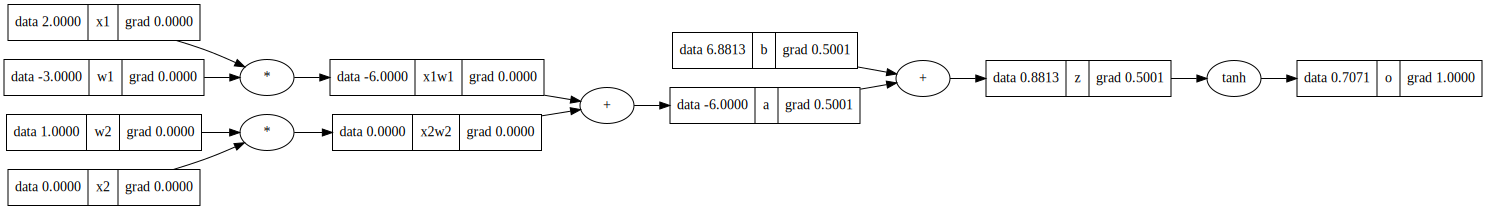

In [60]:
draw_dot(o)

and so on....

How to call all automatically?

In [61]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.8813),
 Value(data=0.8813000000000004),
 Value(data=0.7070699857622339)]

call backward on everything whihc has already happened beforehand , basically topological sort

In [63]:
for i in topo[::-1]:
  i._backward()

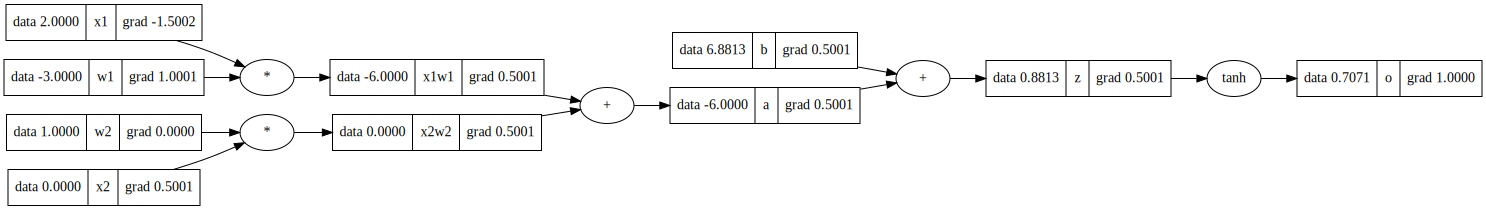

In [65]:
draw_dot(o)

In [69]:
# in one go!!

class Value:
    def __init__(self, data, _children=(), _op="", label = ''): #_children is tuple but set inside
      self.data= data
      self._prev = set(_children)
      self._backward = lambda: None #empty function bcz for leaf node it needs to do nothing and return. therefore cant be None
      self._op = _op
      self.label = label
      self.grad = 0.0


    def __repr__(self):
        return f"Value(data={self.data})"


    def __add__(self, other): # using __add__ it will automatically be invoked when val1 + val2 is called
      out = Value(self.data + other.data, (self, other), "+")

      def _backward():
        self.grad = 1.0 * out.grad
        other.grad = 1.0 * out.grad
      out._backward = _backward

      return out


    def __mul__(self, other): # using __mul__ it will automatically be invoked when val1*val2 is called
      out = Value(self.data*other.data, (self, other), "*")

      def _backward():
        self.grad = other.data * out.grad
        other.grad = self.data * out.grad
      out._backward = _backward

      return out

    def tanh(self):
      x = self.data
      t = ((math.exp(2*x) - 1)/(math.exp(2*x) + 1))
      out = Value(t, (self,), 'tanh')

      def _backward():
        self.grad = (1 - t**2) * out.grad
      out._backward = _backward

      return out


    def backward(self):
      topo = []
      visited = set()

      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)

      build_topo(self)
      self.grad = 1

      for i in topo[::-1]:
        i._backward()

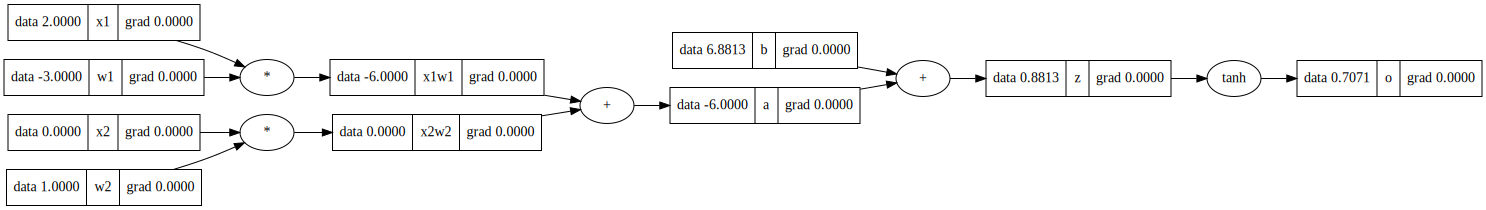

In [71]:
# NEURON

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

b = Value(6.8813, label="b")

x1w1 = x1*w1
x1w1.label = "x1w1"

x2w2 = x2*w2
x2w2.label = "x2w2"

a = x1w1 + x2w2
a.label = "a"

z = a + b
z.label = "z"

o = z.tanh()
o.label = 'o'

draw_dot(o)

In [72]:
o.backward()

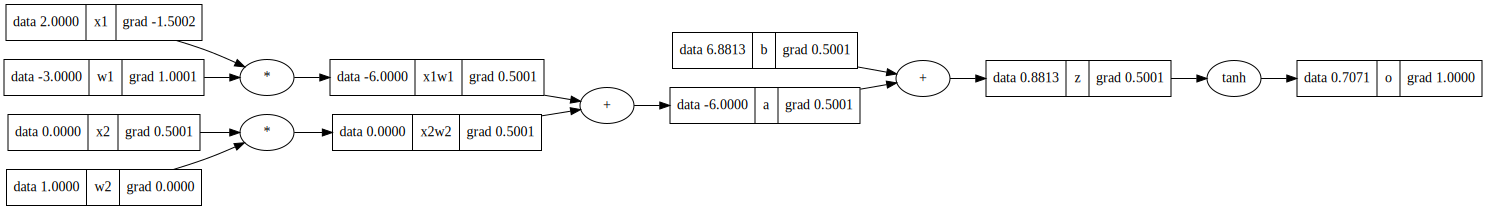

In [73]:
draw_dot(o)

BAD BUG

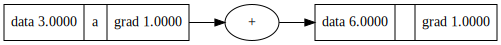

In [74]:
a = Value(3.0, label = 'a')
b = a + a; b.albel = b
b.backward()
draw_dot(b)

derivative should be 2!!


self.grad set to 1

other.grad also set to 1 . overwritten

and self and other are the same thing here..


so always pile up gradients


In [50]:
# in one go!!

class Value:
    def __init__(self, data, _children=(), _op="", label = ''): #_children is tuple but set inside
      self.data= data
      self._prev = set(_children)
      self._backward = lambda: None #empty function bcz for leaf node it needs to do nothing and return. therefore cant be None
      self._op = _op
      self.label = label
      self.grad = 0.0


    def __repr__(self):
        return f"Value(data={self.data})"


    def __add__(self, other): # using __add__ it will automatically be invoked when val1 + val2 is called
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data + other.data, (self, other), "+")

      def _backward():
        self.grad += 1.0 * out.grad
        other.grad += 1.0 * out.grad
      out._backward = _backward

      return out

    def __radd__(self, other): # other + self
      return self + other

    def __mul__(self, other): # using __mul__ it will automatically be invoked when val1*val2 is called
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data*other.data, (self, other), "*")

      def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
      out._backward = _backward

      return out

    def __sub__(self, other):
      return self + other*(-1)

    def exp(self):
      x = self.data
      t = math.exp(x)
      out = Value(t, (self,), 'exp')

      def _backward():
        self.grad += t * out.grad
      out._backward = _backward

      return out

    # since division a/b is a* (b**-1)
    def __truediv__(self, other):
      return self * other**-1

    def __pow__(self, other):
      x = self.data
      t = self.data**other
      out = Value(t, (self,), f'**{other}')

      def _backward():
        self.grad += other* (self.data**(other -1)) * out.grad
      out._backward = _backward

      return out


    def tanh(self):
      x = self.data
      t = ((math.exp(2*x) - 1)/(math.exp(2*x) + 1))
      out = Value(t, (self,), 'tanh')

      def _backward():
        self.grad += (1 - t**2) * out.grad
      out._backward = _backward

      return out



    def backward(self):
      topo = []
      visited = set()

      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)

      build_topo(self)
      self.grad = 1

      for i in topo[::-1]:
        i._backward()

In [2]:
a = Value(2.0)
b = Value(4.0)

print(a - b)
print(a**4)
print(a/b)

Value(data=-2.0)
Value(data=16.0)
Value(data=0.5)


In [3]:
# NEURON

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

b = Value(6.8813, label="b")

x1w1 = x1*w1
x1w1.label = "x1w1"

x2w2 = x2*w2
x2w2.label = "x2w2"

a = x1w1 + x2w2
a.label = "a"

z = a + b
z.label = "z"

o_num =  z.exp()**2 - 1
o_den =  z.exp()**2 + 1

o_num.label = 'o_num'
o_den.label = 'o_den'

o = o_num/o_den
o.label = 'o'

o.backward()
draw_dot(o)


NameError: ignored

In [4]:
import torch
import random

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())  # item() is for scalalr stuff
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [5]:
o.data

tensor([0.7071], dtype=torch.float64)

In [104]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    result = self.b

    for i in zip(self.w, x):
      result+= i[0]*i[1]

    out = result.tanh()

    return out

  def parameters(self):
    return self.w + [self.b]

n = Neuron(2)

In [105]:
x = [2, 3]
n(x)

Value(data=-0.6210137899616579)

In [106]:
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    out = []

    for n in self.neurons:
      out.append(n(x))

    return out[0] if len(out)==1 else out


  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

In [107]:
l = Layer(2, 4)
x = [2, 3]
l(x)

[Value(data=-0.8224316886468743),
 Value(data=0.9982184261767313),
 Value(data=-0.9998942097583269),
 Value(data=-0.9846743899431316)]

In [108]:
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [109]:
mlp = MLP(3, [4, 4, 1])
x = [2, 3, 1]
mlp(x)

Value(data=0.9563367912473931)

In [110]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [111]:
y_pred = [mlp(x) for x in xs]
print(y_pred)

[Value(data=0.9716775960017827), Value(data=-0.002505708489806226), Value(data=0.8906743703433587), Value(data=0.9037857268372773)]


In [112]:
y_pred

[Value(data=0.9716775960017827),
 Value(data=-0.002505708489806226),
 Value(data=0.8906743703433587),
 Value(data=0.9037857268372773)]

In [113]:
a = [(y_p - y_gt)**2 for y_gt, y_p in zip(ys, y_pred)]

In [114]:
a

[Value(data=0.0008021585682382343),
 Value(data=0.9949948615954234),
 Value(data=3.5746495746732565),
 Value(data=0.00925718636023102)]

In [116]:
loss = sum(((y_p - y_gt)**2 for y_gt, y_p in zip(ys, y_pred)))
print(loss)

Value(data=4.579703781197149)


In [117]:
params = mlp.parameters()
print(len(params))

41


In [136]:
for k in range(10):
  y_pred = [mlp(x) for x in xs]
  loss = sum(((y_p - y_gt)**2 for y_gt, y_p in zip(ys, y_pred)))

  # backward pass
  for p in mlp.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in mlp.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 0.00027526327983568477
1 0.0002750202651309752
2 0.00027477767562088804
3 0.00027453551019473977
4 0.00027429376774569465
5 0.0002740524471707501
6 0.0002738115473707346
7 0.0002735710672502745
8 0.0002733310057178038
9 0.0002730913616855145


In [137]:
y_pred
# very near 1, -1, -1, 1

[Value(data=0.9949670289074588),
 Value(data=-0.9942082501094198),
 Value(data=-0.9886394214775593),
 Value(data=0.9907721371646744)]

In [138]:
sum(((y_p - y_gt)**2 for y_gt, y_p in zip(ys, y_pred)))

Value(data=0.0002730913616855145)